In [179]:
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

In [180]:
# load our full coffee data
data = pd.read_csv("../data/processed/preprocessed_data.csv")
# load model embeddings index 
index = faiss.read_index("../data/outputs/faiss/faiss_index.bin")
# load model embeddings
embeddings = np.load("../data/outputs/all_embeddings.npy")

print(type(embeddings)) 

<class 'numpy.ndarray'>


In [181]:
# center and normalize embeddings
scaler = StandardScaler()
normed_emb = scaler.fit_transform(embeddings)

In [182]:
start_time = time.time()


pca = PCA(n_components=2)
pc = pca.fit_transform(normed_emb)

end_time = time.time()

duration = end_time - start_time

print(f"PCA with sklearn took: {duration} seconds")

PCA with sklearn took: 0.050339460372924805 seconds


In [183]:
k_vals = [i for i in range(2, 21)]
best_k = 2
best_sil_score = -1.
sil_scores = {}
X = normed_emb
for k in k_vals:
    print(f"Running {k}-Means")
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    sil_scores[k] = sil_score
    print(f"For k = {k}, Silhouette Score: {sil_score}")
    if sil_score > best_sil_score:
        best_sil_score = sil_score
        best_k = k
        
print(best_k)
print(best_sil_score)

Running 2-Means
For k = 2, Silhouette Score: 0.1414176970720291
Running 3-Means
For k = 3, Silhouette Score: 0.15826880931854248
Running 4-Means
For k = 4, Silhouette Score: 0.16839417815208435
Running 5-Means
For k = 5, Silhouette Score: 0.14054717123508453
Running 6-Means
For k = 6, Silhouette Score: 0.12431493401527405
Running 7-Means
For k = 7, Silhouette Score: 0.13228529691696167
Running 8-Means
For k = 8, Silhouette Score: 0.1478264182806015
Running 9-Means
For k = 9, Silhouette Score: 0.16195979714393616
Running 10-Means
For k = 10, Silhouette Score: 0.16487032175064087
Running 11-Means
For k = 11, Silhouette Score: 0.16526541113853455
Running 12-Means
For k = 12, Silhouette Score: 0.1513928323984146
Running 13-Means
For k = 13, Silhouette Score: 0.15984489023685455
Running 14-Means
For k = 14, Silhouette Score: 0.16360755264759064
Running 15-Means
For k = 15, Silhouette Score: 0.17127537727355957
Running 16-Means
For k = 16, Silhouette Score: 0.15730123221874237
Running 17-Mea

In [184]:
def run_k_means(n_clusters, normed_embeddings, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(normed_embeddings)
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(normed_embeddings)
    
    fig, ax = plt.subplots(figsize=(12, 8))

    unique_labels = np.unique(labels)

    # Generate an array of distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        # Select the 2D points belonging to the current cluster
        cluster_points = embeddings_2d[labels == label]
        
        # Plot the points for the current cluster, assign a unique color and label
        ax.scatter(
            cluster_points[:, 0], 
            cluster_points[:, 1], 
            color=colors[i], 
            label=f'Cluster {label}', 
            alpha=0.7
        )
        
    ax.set_title(f'K-Means Clustering Results (k={n_clusters}) Visualized with PCA')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    ax.legend(title="Clusters", bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

    ax.grid(True)

    plt.subplots_adjust(right=0.8)

    plt.show()

    return labels 

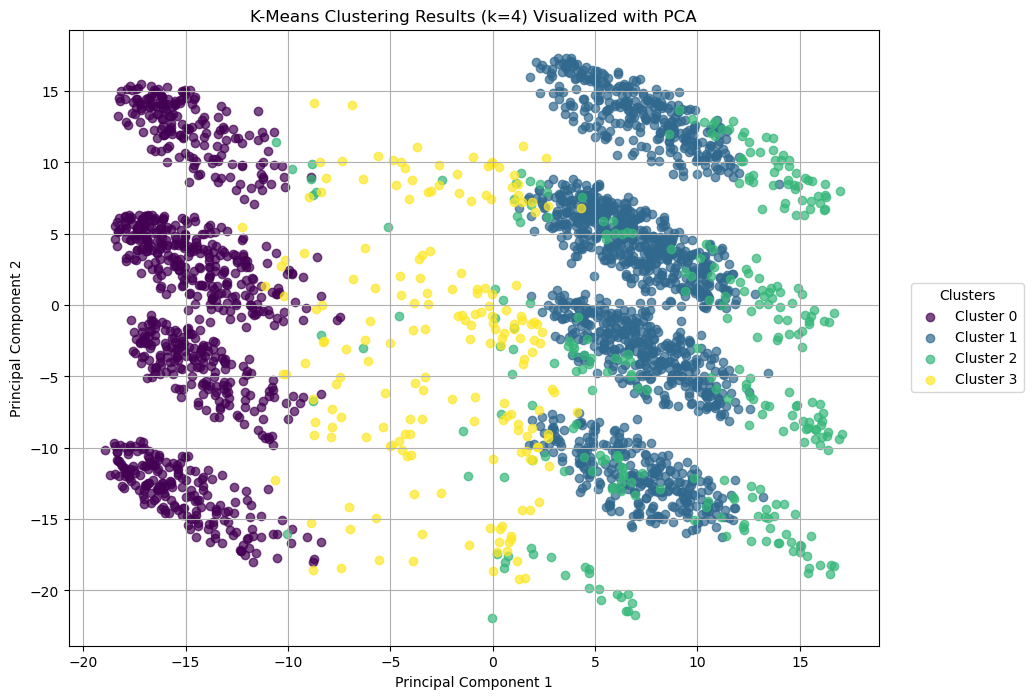

In [185]:
labels_4 = run_k_means(n_clusters=4, normed_embeddings=normed_emb)

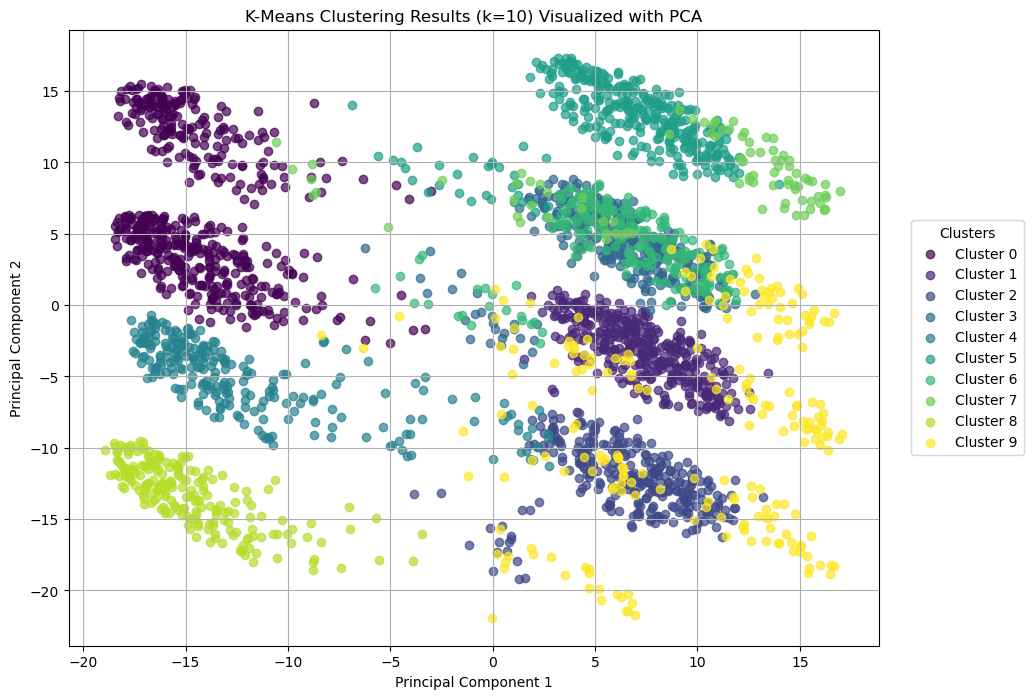

In [186]:
labels_10 = run_k_means(10, normed_emb)

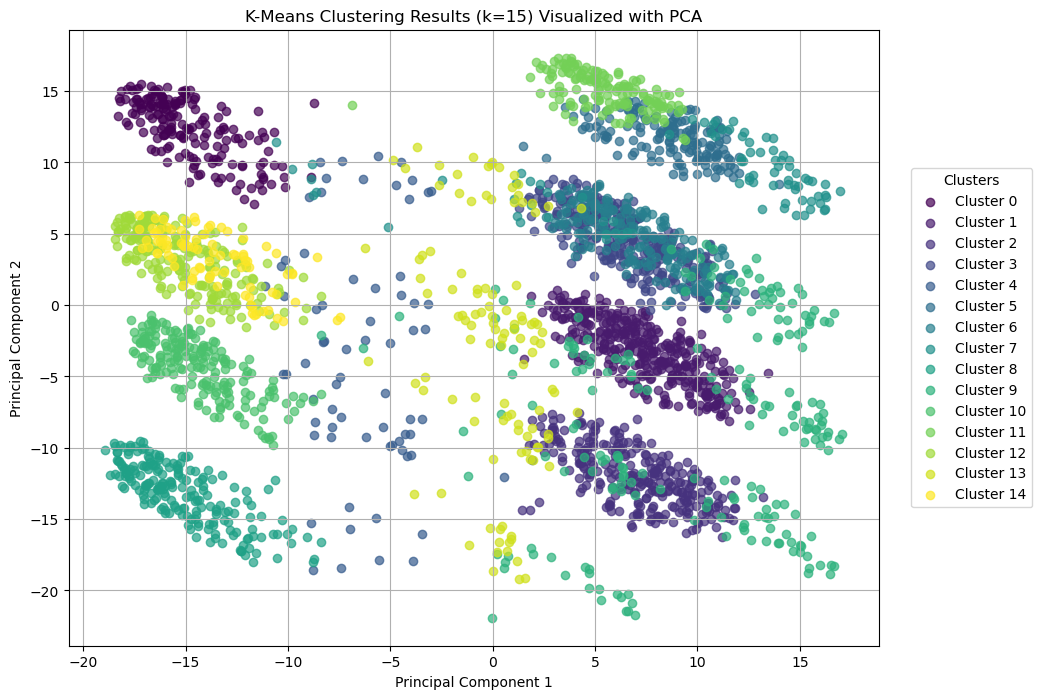

In [187]:
labels_15 = run_k_means(15, normed_emb)

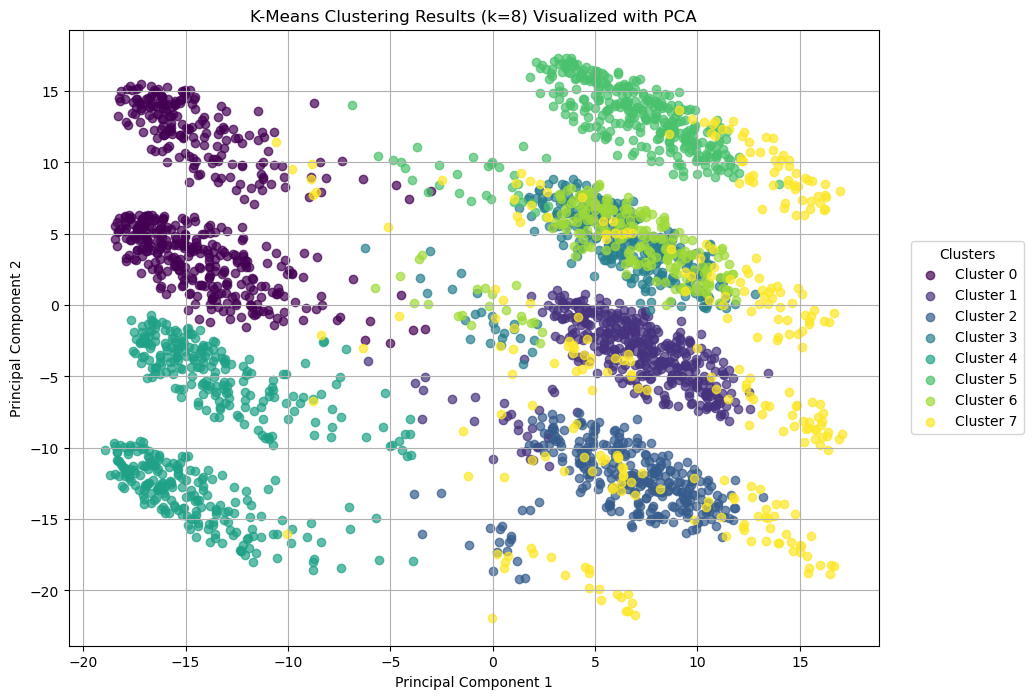

In [188]:
labels_8 = run_k_means(8, normed_emb)

In [222]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from wordcloud import WordCloud

custom_stop_words = text.ENGLISH_STOP_WORDS.union(["notes", "toned", "coffee", "coffees", "process", 
                                                   "processed", "varietal", "visitwww", "com", "gently", "cup", "brew"
                                                   "bag", "shot", "straight", "roaster"])
                                                #    "fruity", "floral", "sweet", "nutty", "cocoa", "spicy", 
                                                #    "roasted", "toasted", "earthy", "herbal", "winey", 
                                                #    "fermented", "savory", "mouthfeel", "acidity", "aftertaste",
                                                #    "defect", "negative"])

def get_tfidf_freq_dict(labels, label, text_data, top_n=10, stop_words=text.ENGLISH_STOP_WORDS, ngram_range=(1,1), max_df=0.8, min_df=3):
    # get texts in the given cluster
    cluster_data = text_data[labels == label]
    
    # create and execute tf-idf vectorizer on cluster data
    vectorizer = TfidfVectorizer(
        stop_words=list(stop_words),
        ngram_range=ngram_range,
        max_df=max_df,
        min_df=min_df
    )
    tfidf_matrix = vectorizer.fit_transform(cluster_data)
    
    feature_names = vectorizer.get_feature_names_out()
    
    summed_tfidf = tfidf_matrix.sum(axis=0)
    
    # flatten matrix and sort it in descending order
    summed_tfidf_arr = np.array(summed_tfidf).flatten()
    
    # extract top keywords
    top_n_keywords_idx = summed_tfidf_arr.argsort()[-top_n:]
    top_n_keywords = feature_names[top_n_keywords_idx][::-1]
    top_n_scores = summed_tfidf_arr[top_n_keywords_idx][::-1]
    
    freq_dict = dict(zip(feature_names, summed_tfidf_arr))
    
    return freq_dict, top_n_keywords
    
    
def create_tfidf_wordcloud(labels, text_data, top_n=10):
    
    # custom_stop_words = text.ENGLISH_STOP_WORDS
    if len(labels) != len(text_data):
        raise ValueError("Labels and texts do no have the same number of elements.")
    
    unique_clusters = np.unique(labels)
    for cluster in unique_clusters:
        freq_dict, top_n_keywords = get_tfidf_freq_dict(labels, cluster, text_data, top_n=top_n, stop_words=custom_stop_words)
        print(f"Top {top_n} words: {', '.join(top_n_keywords)}")
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            colormap="viridis"
        ).generate_from_frequencies(freq_dict)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Top Keywords for Cluster {cluster}")
        plt.savefig(f"cluster {cluster} wordcloud.png")
        plt.show()
        

def create_tfidf_histogram(labels, text_data, top_n=10):
    
    # custom_stop_words = text.ENGLISH_STOP_WORDS
    if len(labels) != len(text_data):
        raise ValueError("Labels and texts do no have the same number of elements.")
    
    unique_clusters = np.unique(labels)
    for cluster in unique_clusters:
        freq_dict, top_n_keywords = get_tfidf_freq_dict(labels, cluster, text_data, top_n=top_n, stop_words=custom_stop_words)
        top_n_freqs = []
        for keyword in top_n_keywords:
            top_n_freqs.append(freq_dict[keyword])
        print(top_n_keywords)
        print(top_n_freqs)
        plt.figure(figsize=(10, 7))
        plt.barh(top_n_keywords, top_n_freqs, color='skyblue')
        plt.xlabel("Summed TF-IDF Score")
        plt.ylabel("Keywords")
        plt.title(f"Top Keywords for Cluster {cluster}")
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"cluster {cluster} histogram.png") 
        plt.show()
        
        

Top 10 words: sweet, cocoa, nib, chocolate, floral, tart, bright, syrupy, juicy, structure


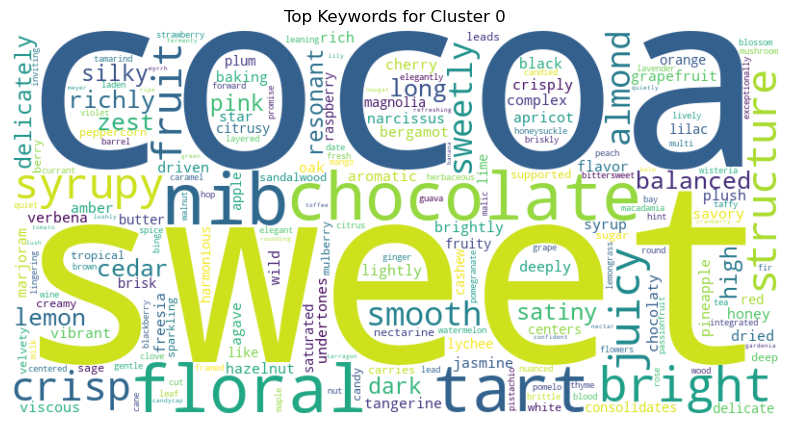

Top 10 words: sweet, chocolate, cocoa, cedar, structure, tart, nib, savory, dark, richly


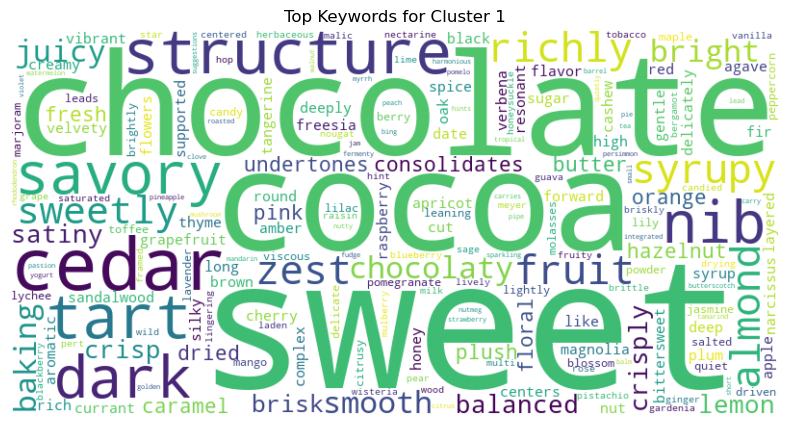

Top 10 words: sweet, chocolate, cocoa, tart, structure, cedar, nib, dark, sweetly, richly


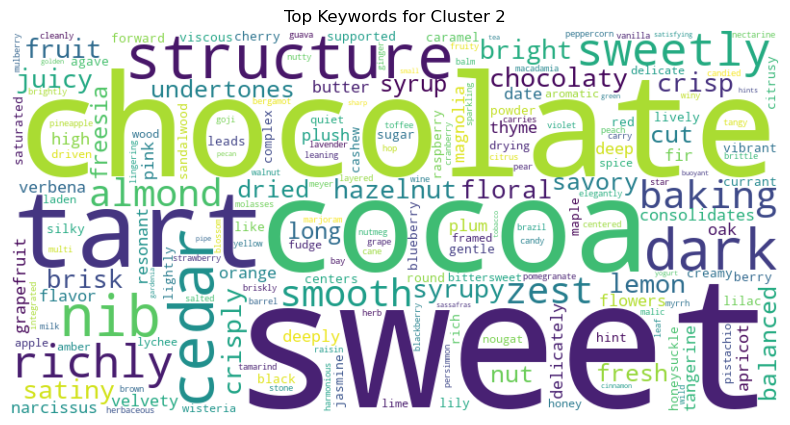

Top 10 words: sweet, chocolate, cocoa, tart, structure, cedar, nib, zest, syrupy, richly


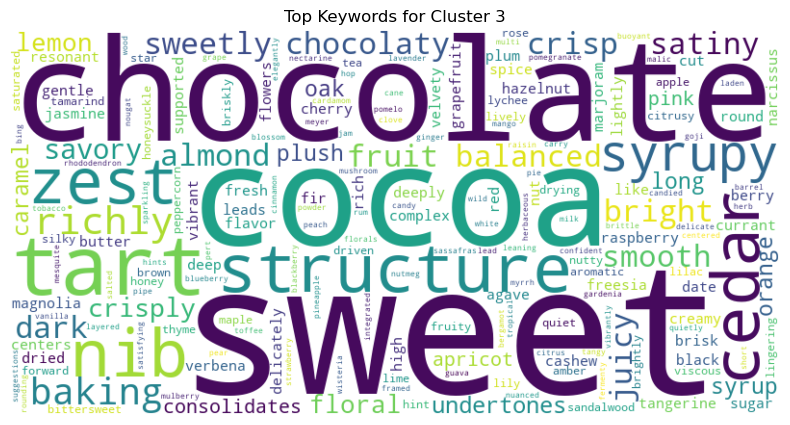

Top 10 words: sweet, chocolate, cocoa, aroma, acidity, structure, scorched, tart, baking, savory


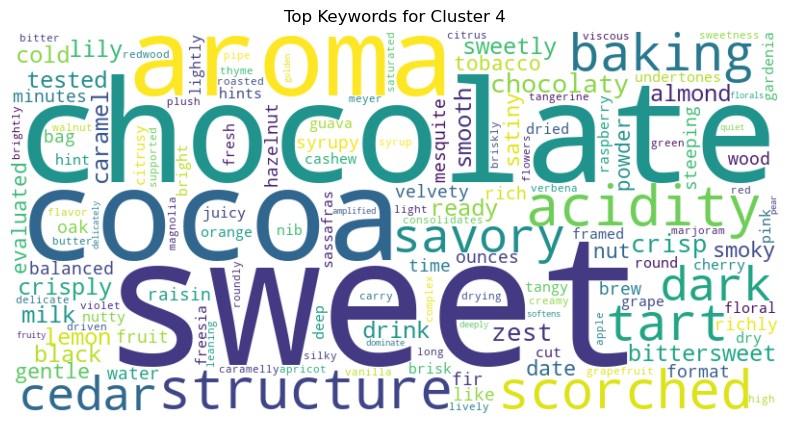

Top 10 words: sweet, cocoa, chocolate, almond, zest, cedar, baking, structure, chocolaty, crisply


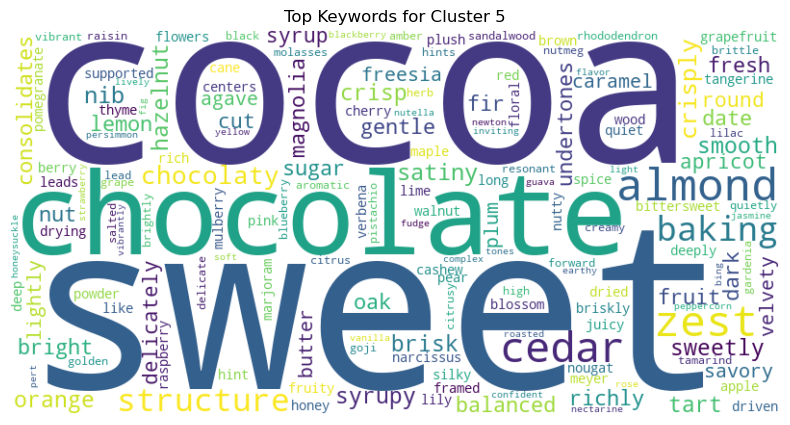

Top 10 words: cocoa, chocolate, structure, tart, zest, nib, cedar, syrupy, dark, baking


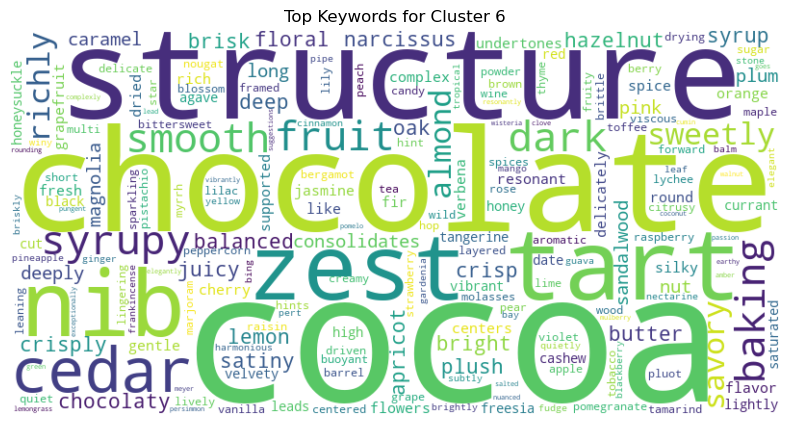

Top 10 words: chocolate, chocolaty, dark, sweet, milk, richly, cedar, fruit, floral, parts


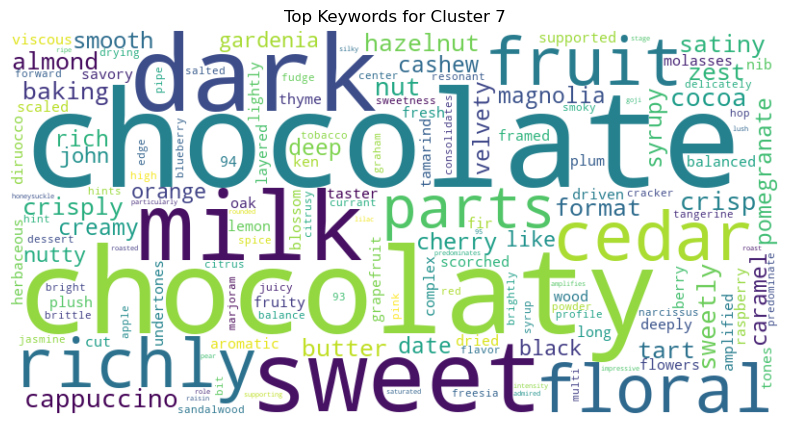

Top 10 words: cocoa, sweet, nib, tart, chocolate, richly, sweetly, bright, juicy, lemon


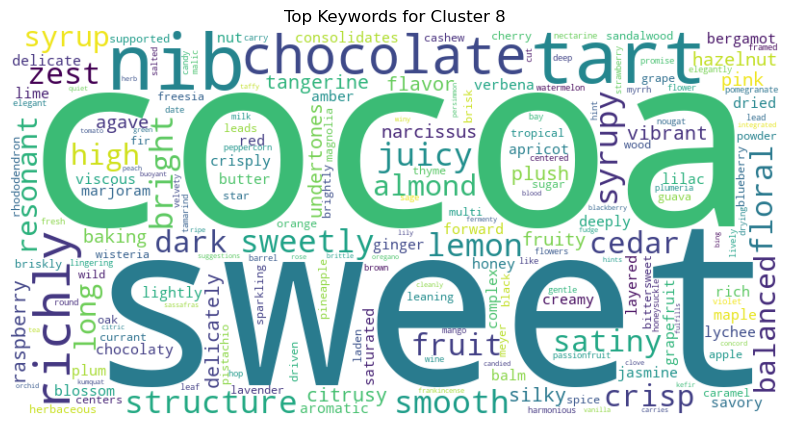

Top 10 words: chocolate, chocolaty, dark, sweet, cedar, milk, parts, nut, richly, tart


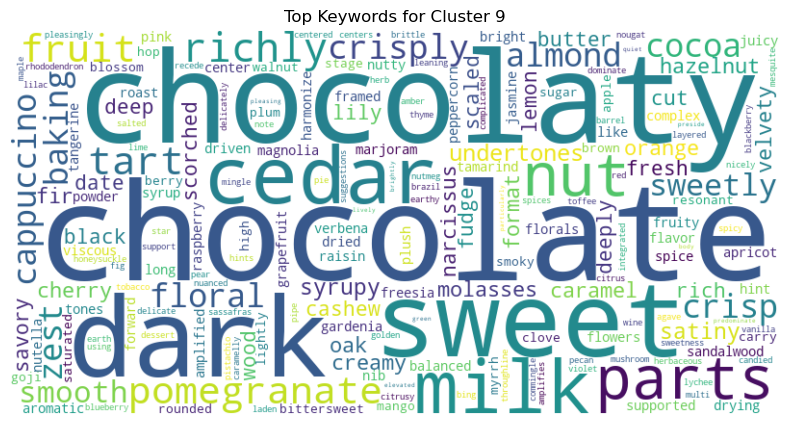

Top 10 words: cocoa, sweet, nib, chocolate, tart, structure, bright, syrupy, juicy, sweetly


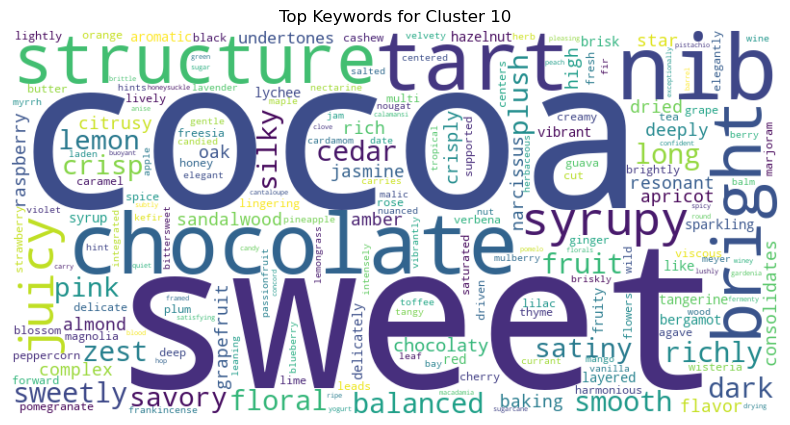

Top 10 words: sweet, cocoa, chocolate, tart, nib, structure, syrupy, juicy, fruit, sweetly


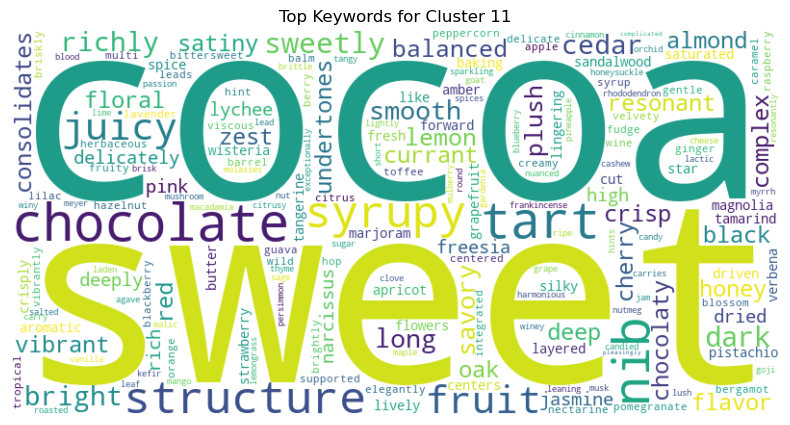

Top 10 words: cocoa, sweet, nib, tart, chocolate, structure, syrupy, richly, juicy, bright


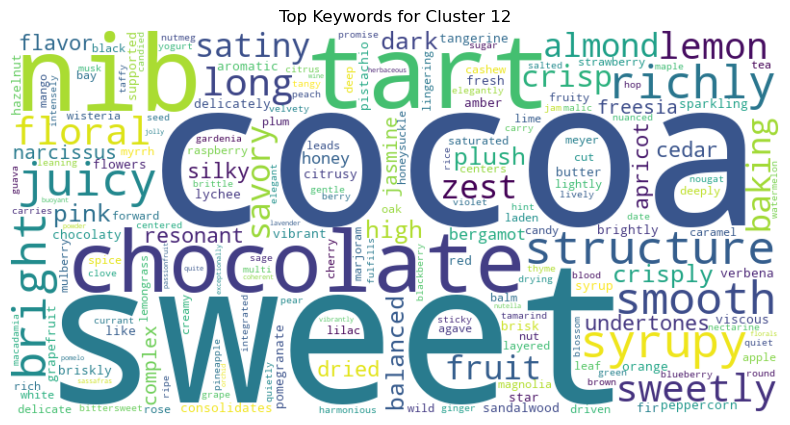

Top 10 words: chocolate, sweet, chocolaty, cocoa, cedar, dark, structure, scorched, gentle, oak


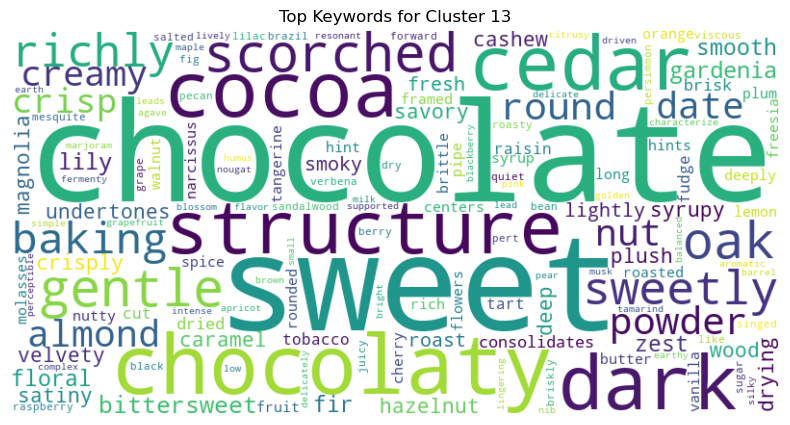

Top 10 words: sweet, cocoa, nib, tart, structure, zest, chocolate, bright, richly, sweetly


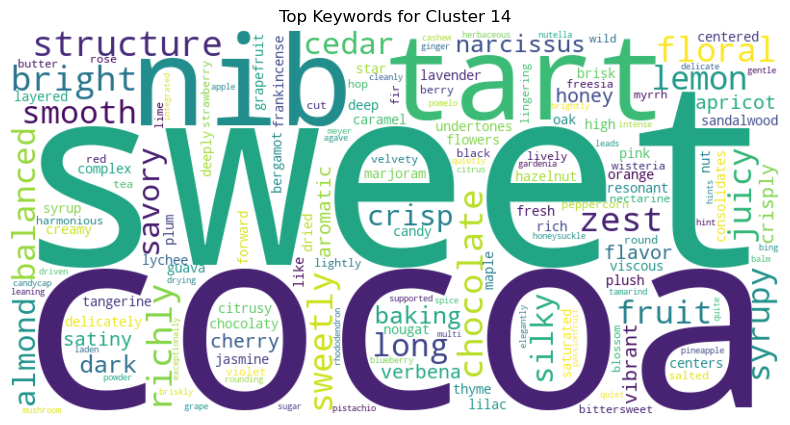

In [223]:
        
text_data = np.array(data["blind assessment"])
# text_data = np.array(data["roast level"].fillna(""))        
create_tfidf_wordcloud(labels_15, text_data)

['sweet' 'cocoa' 'nib' 'chocolate' 'floral' 'tart' 'bright' 'syrupy'
 'juicy' 'structure']
[15.123574606425072, 14.75479829883691, 11.738991668095329, 10.191148645205178, 10.118569710198685, 9.883332755569594, 8.929859912359882, 8.830615494039902, 8.799305776311359, 8.716513398604295]


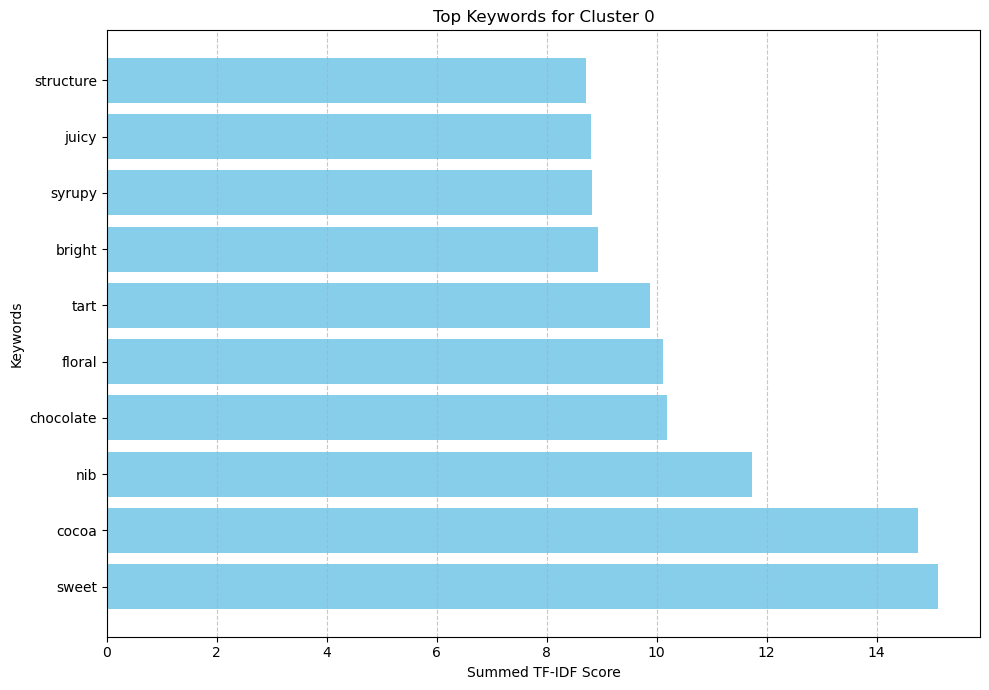

['sweet' 'chocolate' 'cocoa' 'cedar' 'structure' 'tart' 'nib' 'savory'
 'dark' 'richly']
[29.63620816456259, 25.741366337331684, 25.30733438908959, 21.375889328824154, 19.885774041024934, 19.248212033760097, 17.251015138648906, 17.104292862432597, 16.979886282533666, 16.425179464518262]


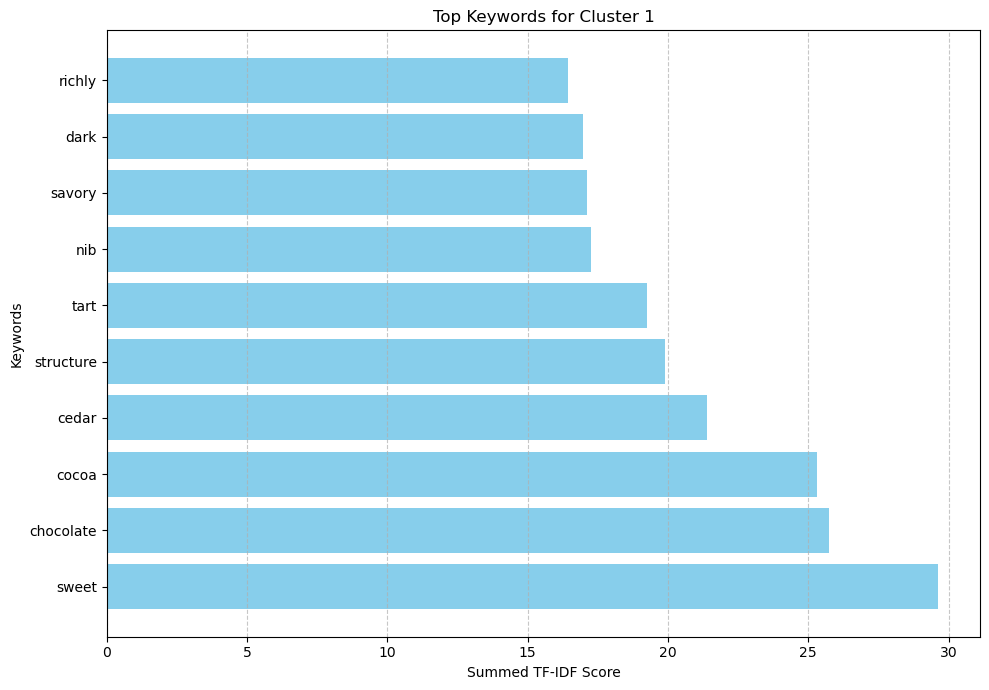

['sweet' 'chocolate' 'cocoa' 'tart' 'structure' 'cedar' 'nib' 'dark'
 'sweetly' 'richly']
[25.051962611829705, 23.07087394153203, 19.704138383686914, 17.881493868259803, 16.07971706376467, 15.82537409675862, 13.891754294339675, 13.769225726582894, 13.449632657422123, 13.385635138869196]


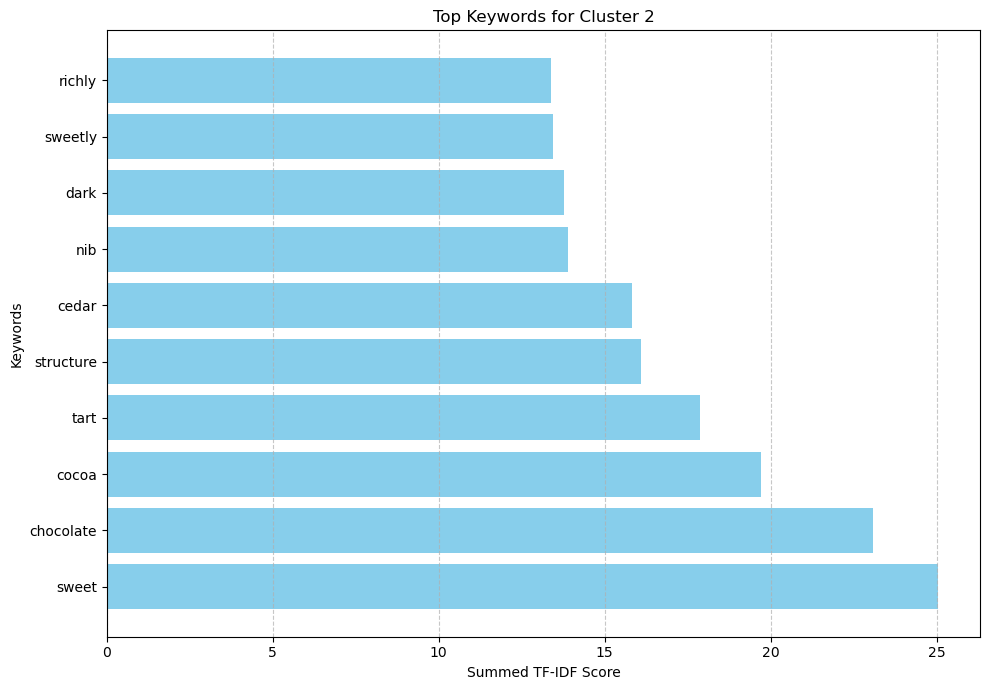

['sweet' 'chocolate' 'cocoa' 'tart' 'structure' 'cedar' 'nib' 'zest'
 'syrupy' 'richly']
[26.124274107400606, 23.0343243055809, 22.588660331153463, 17.70083004761904, 16.924122748914563, 16.652446025162025, 16.489159064368074, 15.261377349448678, 14.773785019563602, 14.713410837464638]


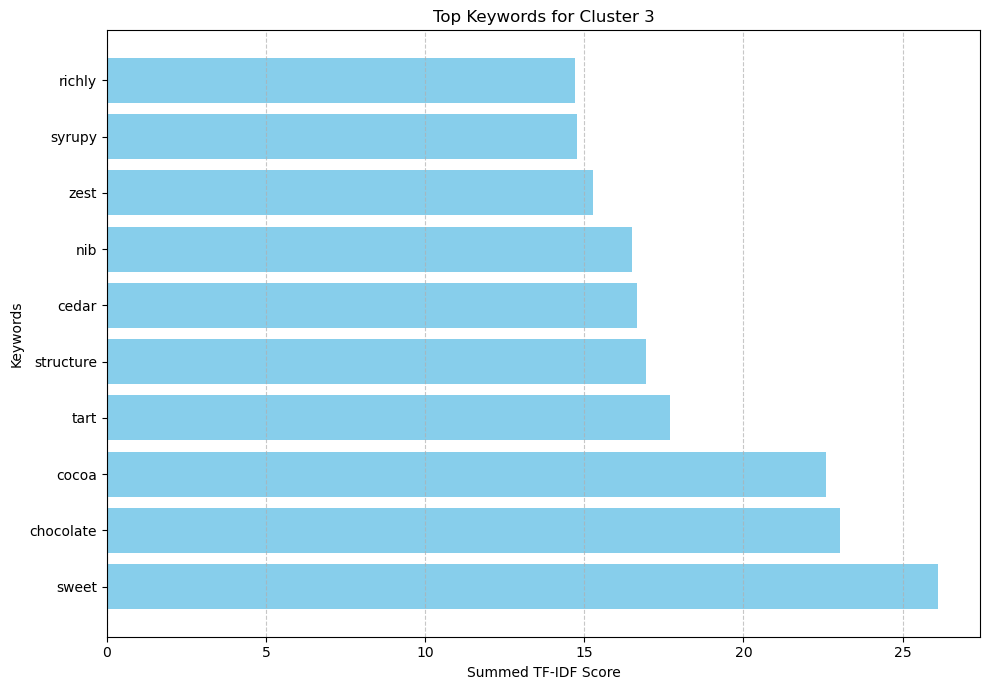

['sweet' 'chocolate' 'cocoa' 'aroma' 'acidity' 'structure' 'scorched'
 'tart' 'baking' 'savory']
[7.340548419928053, 6.723084077328235, 5.431561664685425, 4.805337067219007, 4.726235685453548, 4.615041014157476, 4.3642036055460895, 4.083647435743377, 4.029960920156201, 3.9696027487047436]


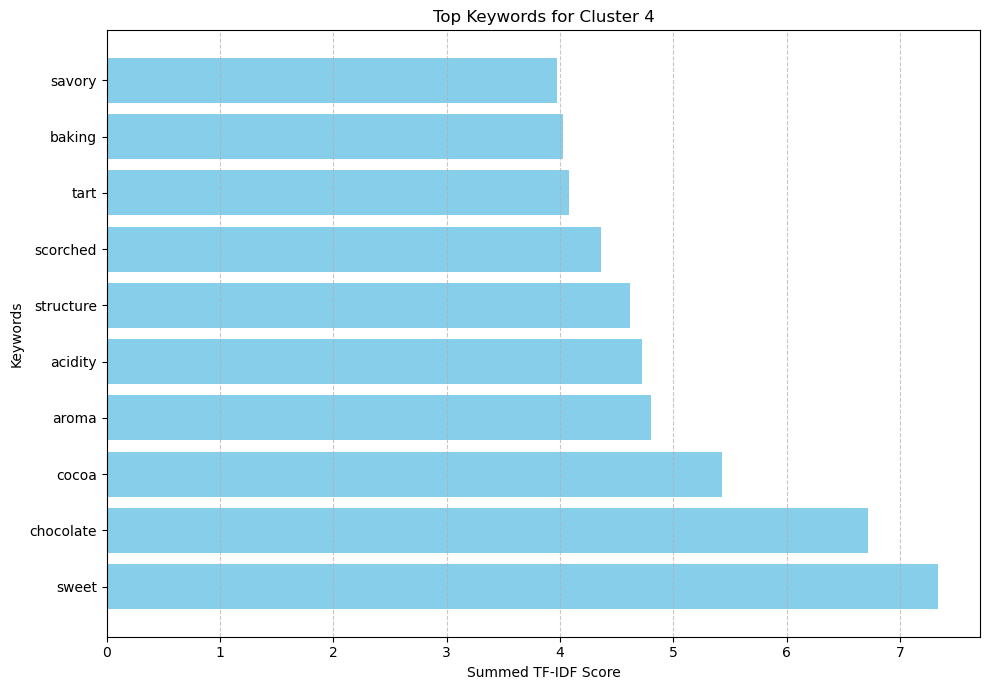

['sweet' 'cocoa' 'chocolate' 'almond' 'zest' 'cedar' 'baking' 'structure'
 'chocolaty' 'crisply']
[16.390637205571657, 14.833096788852002, 13.455586470310891, 11.379576120688064, 10.917537331575867, 10.391696777311315, 10.340653253180406, 9.750380998897363, 9.739035082930625, 9.135493878004771]


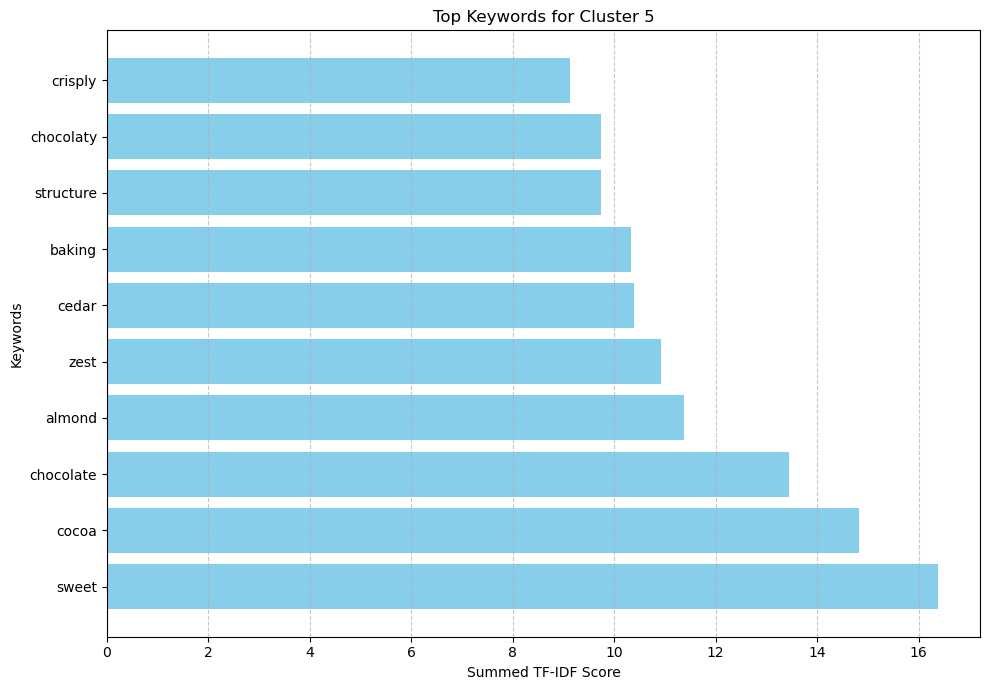

['cocoa' 'chocolate' 'structure' 'tart' 'zest' 'nib' 'cedar' 'syrupy'
 'dark' 'baking']
[15.995980813119179, 15.701830667110396, 12.556723428314521, 12.348263213394551, 10.450202929740424, 10.39945025657737, 10.078737080819318, 10.060099891615081, 9.841227997608206, 9.581904876730855]


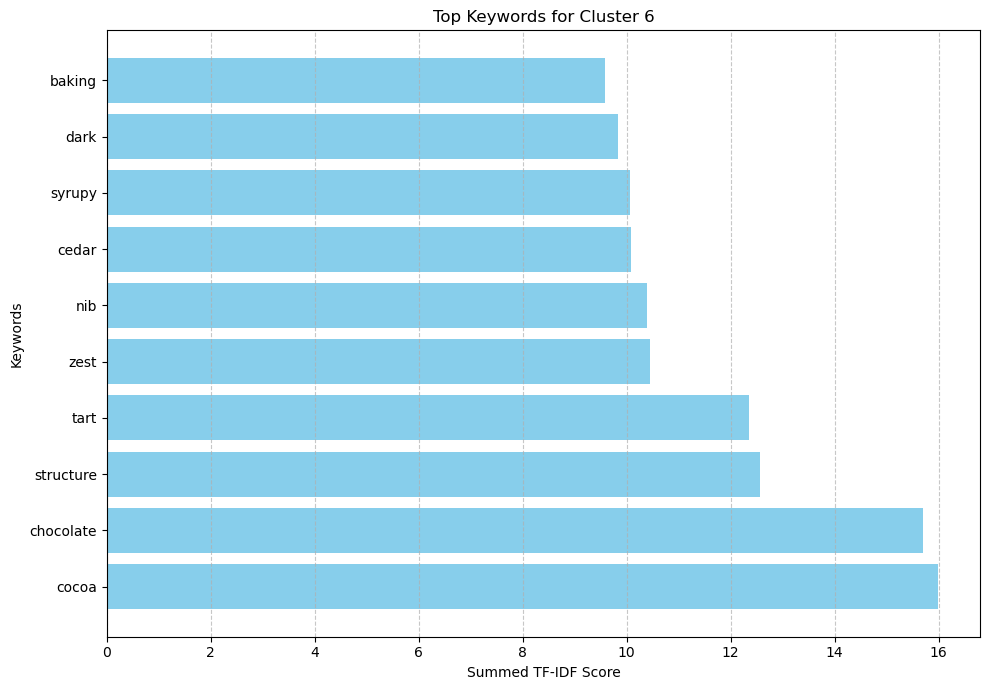

['chocolate' 'chocolaty' 'dark' 'sweet' 'milk' 'richly' 'cedar' 'fruit'
 'floral' 'parts']
[10.507609745414415, 8.309179211095191, 7.150072645875684, 6.189801934043458, 5.873906296749496, 5.473247543841414, 5.46777076247675, 5.271350254287337, 5.195076385116713, 4.9913618285613435]


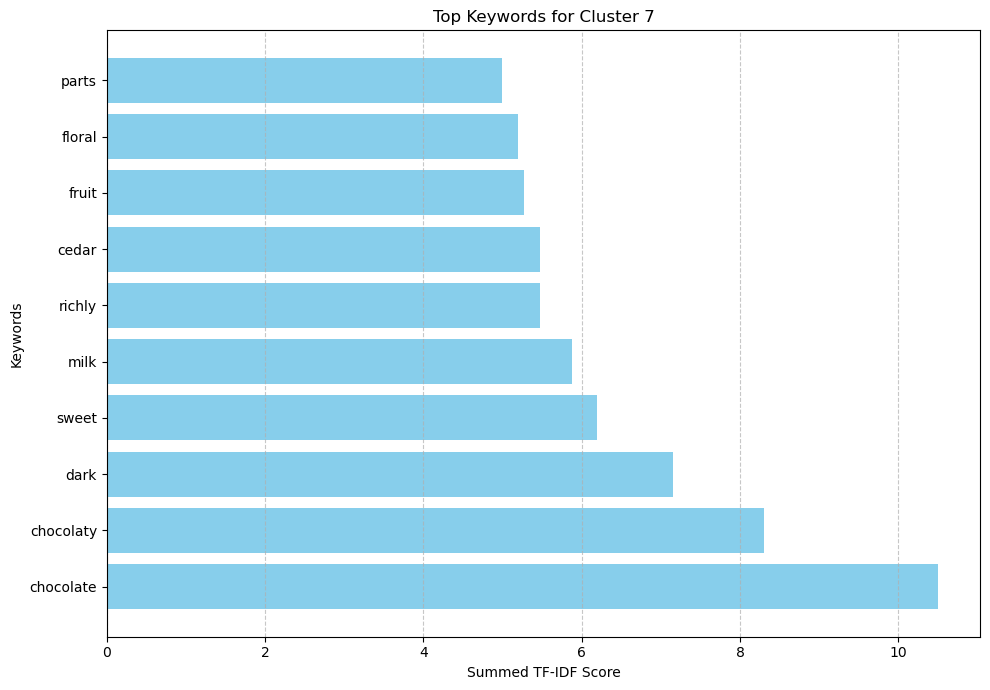

['cocoa' 'sweet' 'nib' 'tart' 'chocolate' 'richly' 'sweetly' 'bright'
 'juicy' 'lemon']
[18.26182613340199, 15.94210213700817, 13.839650221633772, 12.894997424469661, 12.053934450066464, 10.297091365293756, 10.175098031789704, 10.100314179960217, 9.84790943723927, 9.664505870921342]


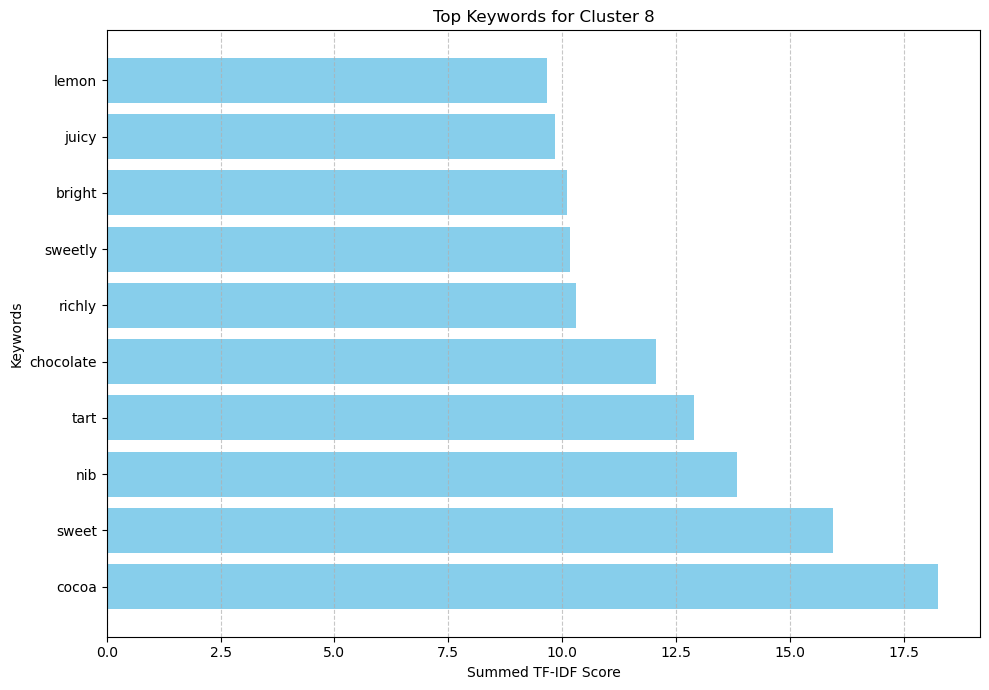

['chocolate' 'chocolaty' 'dark' 'sweet' 'cedar' 'milk' 'parts' 'nut'
 'richly' 'tart']
[24.477591683941846, 21.08616401489652, 15.609540267637891, 14.291267353275089, 14.073517925977125, 13.753078603136753, 12.453483244203232, 12.351612405872874, 12.132504075829376, 11.712575794939616]


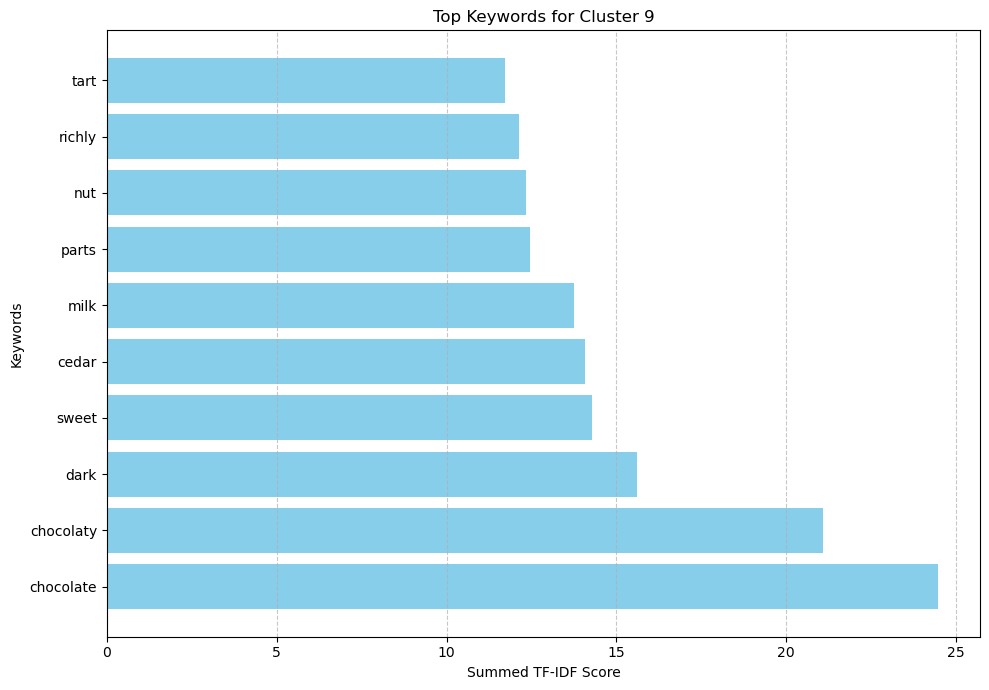

['cocoa' 'sweet' 'nib' 'chocolate' 'tart' 'structure' 'bright' 'syrupy'
 'juicy' 'sweetly']
[15.819638456355179, 15.006069996414976, 12.40892169941596, 11.694477837432917, 11.092767630149353, 9.466063849043596, 9.45302293725612, 9.0430540075481, 9.01297823450855, 8.908129176802117]


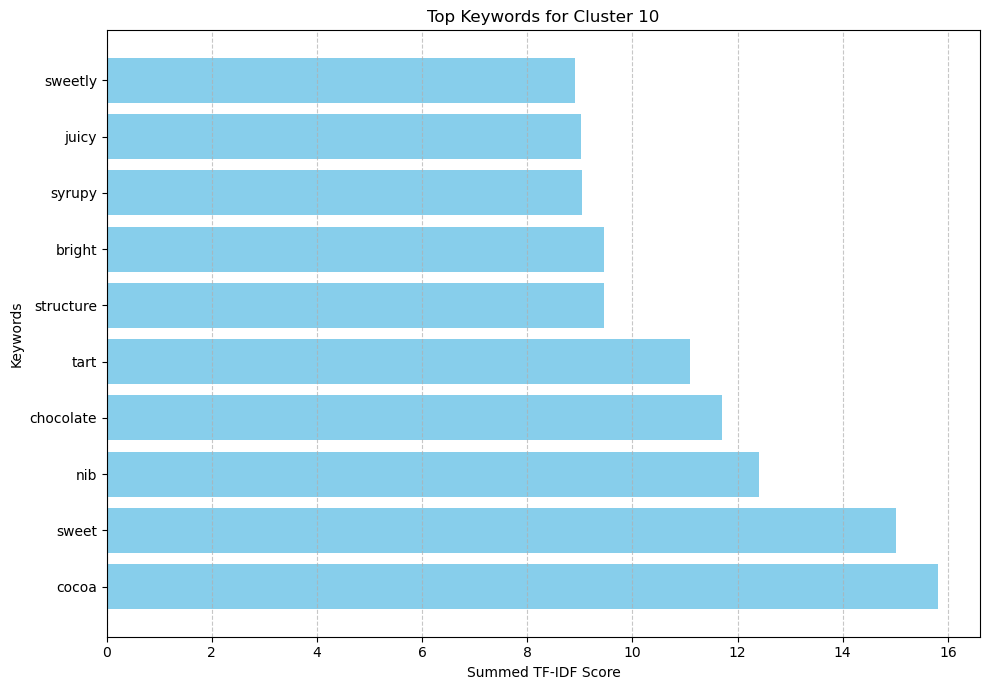

['sweet' 'cocoa' 'chocolate' 'tart' 'nib' 'structure' 'syrupy' 'juicy'
 'fruit' 'sweetly']
[11.225923328767237, 11.152223959783734, 9.944825510173102, 9.054196583114443, 8.908678057352553, 8.295943941219397, 8.287164842852915, 8.285080598144097, 8.207258443449035, 8.162354421203316]


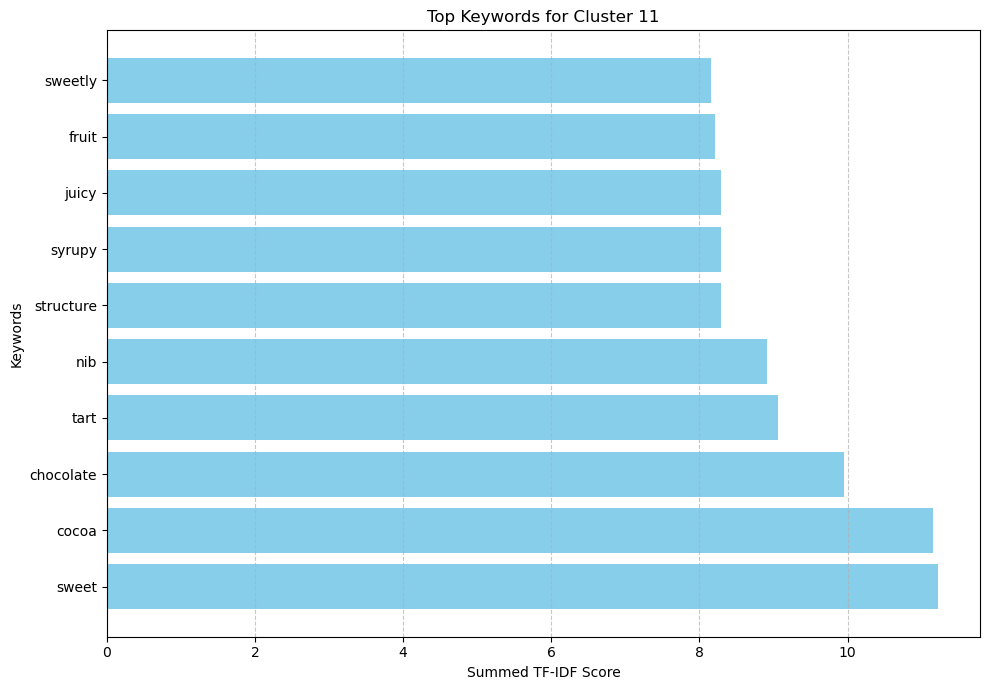

['cocoa' 'sweet' 'nib' 'tart' 'chocolate' 'structure' 'syrupy' 'richly'
 'juicy' 'bright']
[18.906996764441065, 17.061421707026497, 14.740175159503977, 13.935922949145604, 12.500194478347057, 10.591161262774527, 10.48047433166334, 9.973783707378754, 9.944113848719315, 9.824059242892526]


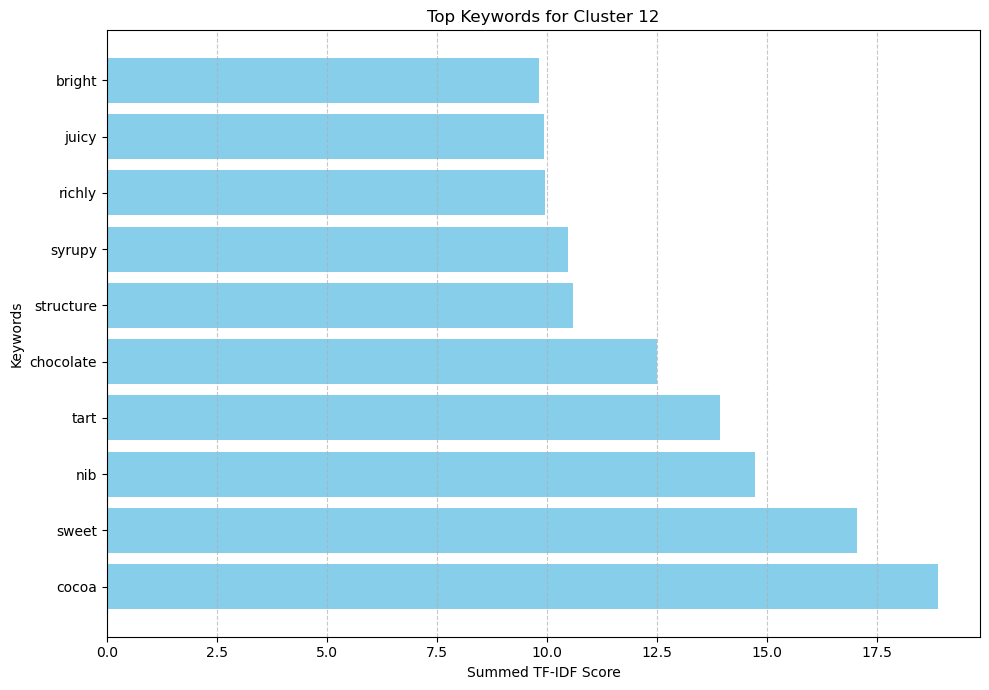

['chocolate' 'sweet' 'chocolaty' 'cocoa' 'cedar' 'dark' 'structure'
 'scorched' 'gentle' 'oak']
[11.089786411885472, 10.532105461888163, 9.47476632144994, 8.67523165793201, 7.954759030267669, 7.874420015195214, 7.3983763282670845, 7.007724452152925, 6.672108901236387, 6.478928989411228]


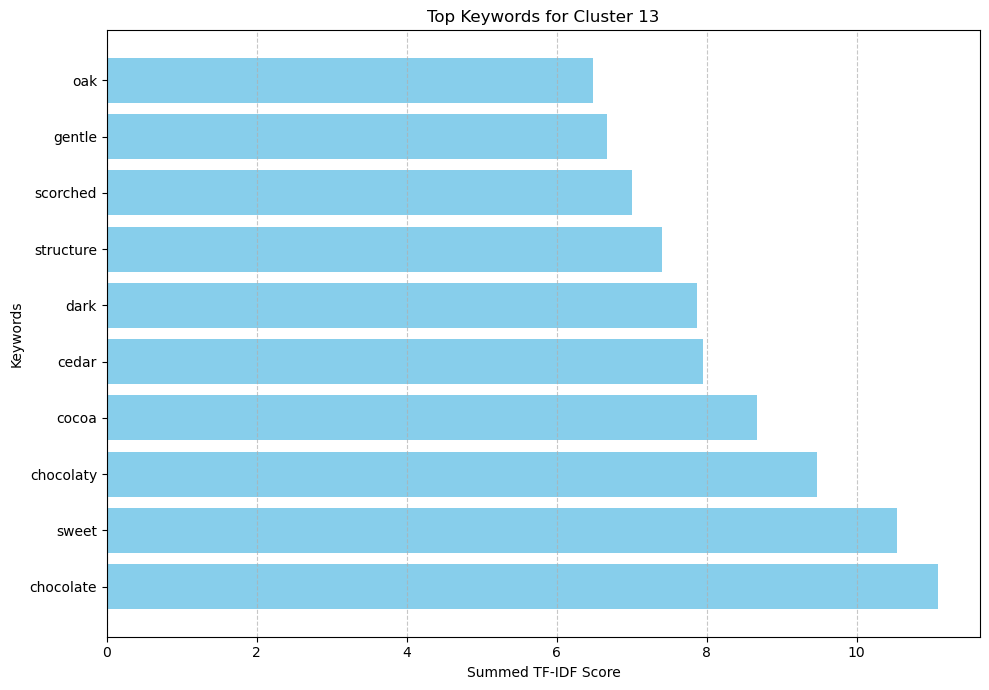

['sweet' 'cocoa' 'nib' 'tart' 'structure' 'zest' 'chocolate' 'bright'
 'richly' 'sweetly']
[8.1958528251217, 8.144904132246316, 6.046902994315452, 5.44793163916352, 5.374025793216406, 5.2006353519882556, 5.122139306143653, 5.03224934117793, 5.00549979638615, 4.757118944154004]


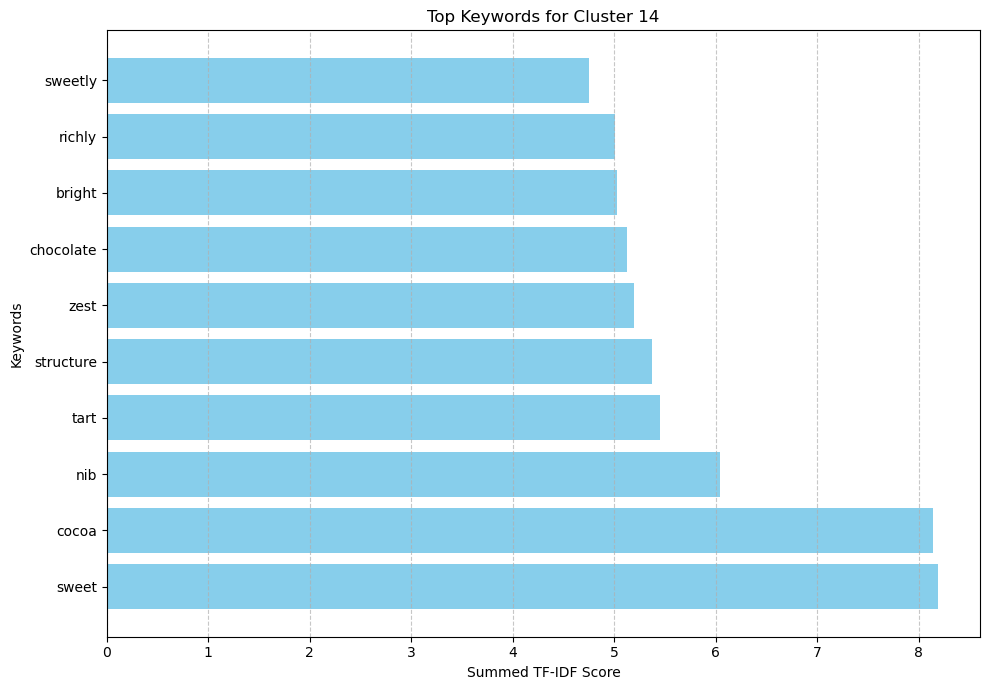

In [224]:
create_tfidf_histogram(labels_15, text_data)

In [192]:
cluster_keywords_map = {}
for label in np.unique(labels_4):
    _, top_n_keywords = get_tfidf_freq_dict(labels_4, label, text_data, stop_words = custom_stop_words)
    cluster_keywords_map[label] = set(top_n_keywords)
 
shared_words = cluster_keywords_map[0]
for i in range(1, 4):
    shared_words = shared_words & cluster_keywords_map[i]
    
shared_words

{'chocolate'}